# Memory Efficient Queries

Part 6 of this tutorial described how to use the `aligned_windows` to return `StatPoint` objects that give summary statistics for time intervals at different levels of the tree database. Here, we describe how to mine these `StatPoint` objects do different types of analysis.

In [1]:
import btrdb
import yaml
from datetime import datetime
from btrdb.utils import timez

In [2]:
# Make sure you add your API key to the config file to connect!
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
conn = btrdb.connect(config['connection']['api_url'], config['connection']['api_key'])

In [3]:
streams = conn.streams_in_collection('sunshine', tags={"unit": "amps"})
stream = streams[0]
print(stream.collection, stream.name, stream.unit)

sunshine/PMU6 C3MAG amps


## What was the maximum?

In [4]:
pw = 50

START = stream.earliest()[0].time
END = stream.latest()[0].time
VERSION = 0

windows, _ = zip(*stream.aligned_windows(start=START, end=END, pointwidth=pw))

max_val = max([w.max for w in windows])
print('Max value is %.2f amps'%(max_val))

Max value is 503.07 amps


## OK, but *when* did it happen?

In [5]:
for i, window in enumerate(windows):
    if window.max == max_val:
        break

interval_start = timez.ns_to_datetime(window.time)
interval_end = timez.ns_to_datetime(window.time + 2**pw)

str_fmt = '%Y-%m-%d'
print('Max value occurred between %s and %s'%(interval_start.strftime(str_fmt), interval_end.strftime(str_fmt)))

Max value occurred between 2016-03-28 and 2016-04-10


Aligned windows tells us the max value within a time range, but doesn't tell us *when* in that time range it happened

### Getting more specific
We can get more specific by iteratively decreasing the point width. Recall that at each level in the tree, the parent node is time-partitioned into 64 intervals. We can look at the max value in each of those 64 intervals, and then zoom in from there to figure out more precisely where to look.

In [6]:
def find_max(stream, start=START, end=END, pw=pw, version=0):
    windows, _ = zip(*stream.aligned_windows(start=start, end=end, pointwidth=pw, version=version))
    target = max([w.max for w in windows])

    for w in windows:
        if w.max == target:
            start, end = w.time, w.time + 2**pw
            if pw >= 32:
                pw = pw - 1
                point = find_max(stream, start=start, end=end, pw=pw, version=version)
            else:
                points, _ = zip(*stream.values(start=start, end=end, version=version))
                for point in points:
                    if point.value == target:
                        return point
    return point


In [7]:
max_point = find_max(stream, start=START, end=END, pw=pw, version=VERSION)

In [8]:
print(max_point)

RawPoint(1459430776374999000, 503.07232666015625)


## Plot the result

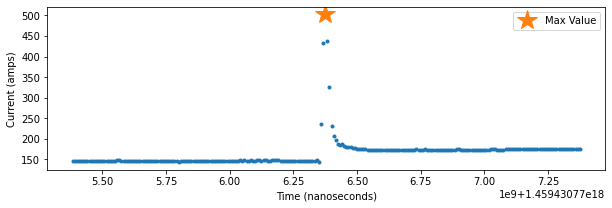

In [9]:
import matplotlib.pyplot as plt
vals, _ = zip(*stream.values(start=max_point.time-1e9, end=max_point.time+1e9, version=VERSION))

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(*zip(*vals), ls=' ', marker='.')
ax.plot(max_point.time, max_point.value, ls=' ', marker='*', ms=20, label='Max Value')
ax.set_xlabel('Time (nanoseconds)')
ax.set_ylabel('Current (%s)'%(stream.unit))
plt.legend()
plt.show()